In [94]:
%reset -f
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [95]:
def display_mag_freq(img_freq):
    img_freq_aux_mag = np.abs(img_freq)
    img_freq_aux_mag[0,0] = 0.0
    img_freq_aux_mag_display = np.log10(1 + np.fft.fftshift(img_freq_aux_mag))
    plt.figure(figsize=(12,12))
    plt.imshow(img_freq_aux_mag_display, cmap='gray')
    plt.axis('off')
    plt.show()

# Projeto 1-2: Restauração de uma imagem de sinalização de trânsito

Você está trabalhando em um projeto da nova versão do PatoPatoVai Street View. Seu objetivo é melhorar a qualidade das imagens obtidas pela câmera do veículo, especialmente em relação ao *motion blur* (pois a câmera está fixada no carro, e os solavancos da estrada podem resultar em borramento das imagens capturadas).

Considere a imagem abaixo:

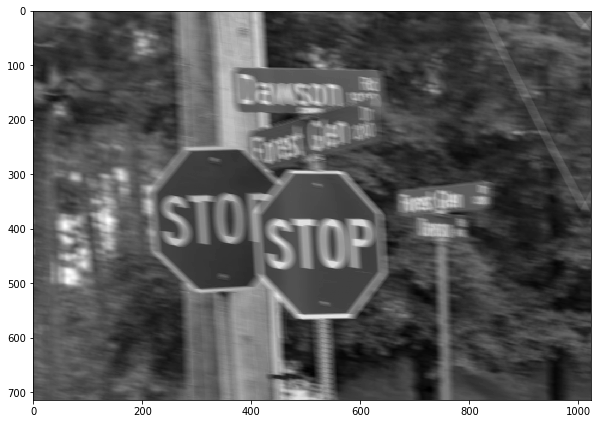

In [96]:
img_blur = cv2.cvtColor(cv2.imread('blur.png'), cv2.COLOR_BGR2GRAY) / 255.0



plt.figure(figsize=(10, 8))
plt.imshow(img_blur, cmap='gray');

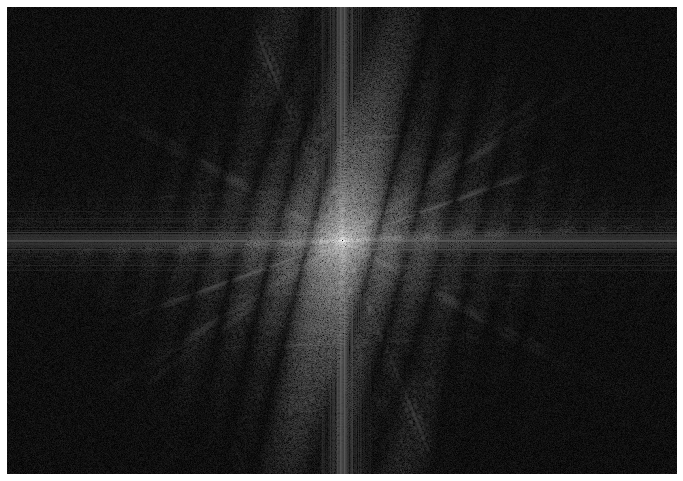

In [97]:
img_test_freq = np.fft.fft2(img_blur)

display_mag_freq(img_test_freq)

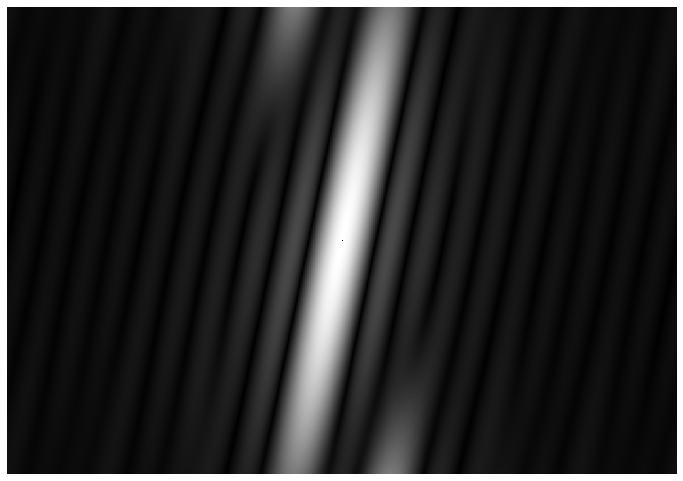

In [126]:
img_test_freq = np.fft.fft2(make_psf(img_blur.shape,20,-8))

display_mag_freq(img_test_freq)

Está difícil saber a que altura da rua Forest Glen estamos. Sua equipe está desenvolvendo um primeiro protótipo de um sistema que, a partir desta imagem, gera uma imagem nítida e com perspectiva corrigida de cada uma das placas indicadoras da rua.

Você foi encarregado de fazer uma primeira versão do melhoramento de imagem (*deblurring*, contraste, correção de perspectiva), onde parâmetros essenciais do *deblurring* (tamanho de kernel, orientação, tipo), do contraste e da correção de perspectiva (pontos notáveis) podem ser determinados manualmente. Na sua equipe tem outros engenheiros trabalhando no problema de detectar e segmentar as placas presentes na cena. 

Para facilitar a experimentação:

- O Scikit-Image já tem uma função que faz o filtro de Wiener: ``skimage.restoration.wiener``

- Segue código para fazer um *kernel* de *motion blur* dado o tamanho do kernel, o comprimento do segmento de reta, e o ângulo.

In [127]:
from skimage.restoration import wiener

def make_psf(shape, length, angle):
    psf = np.zeros(shape)
    rows, cols = shape
    center = (cols//2, rows//2)
    psf[center[1], center[0]:(center[0]+length)] = 1.0
    M = cv2.getRotationMatrix2D(center, angle, 1)
    psf = cv2.warpAffine(psf, M, (cols, rows))
    psf = psf / psf.sum()
    return psf

def plot_image(img, figsize=(12,12), axis='off'):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis(axis)
    plt.show()
    
def faz_gigante(img_blur):
    rows, cols = img_blur.shape
    img_blur_giant = np.zeros((2*rows, 2*cols))
    img_blur_giant[:rows, :cols] = img_blur
    img_blur_giant[:rows, cols:] = img_blur[:, ::-1]
    img_blur_giant[rows:, :cols] = img_blur[::-1, :]
    img_blur_giant[rows:, cols:] = img_blur[::-1, ::-1]
    return img_blur_giant, rows, cols

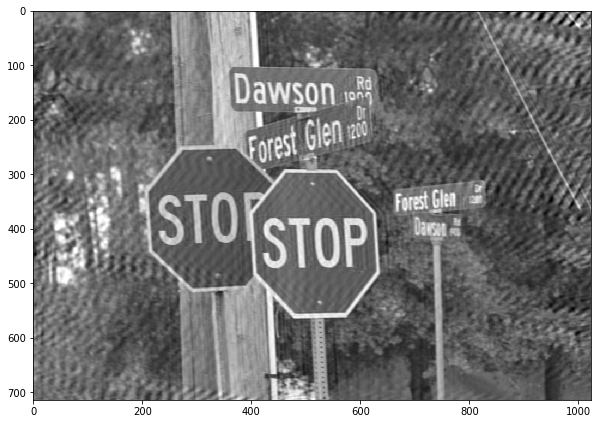

In [128]:
g,rows,cols = faz_gigante(img_blur)
psf = make_psf(g.shape,20,-10)
corrected_img = wiener(g,psf,0.01)

corrected_img = corrected_img[:rows, :cols]

plt.figure(figsize=(10, 8))
plt.imshow(corrected_img, cmap='gray',vmin = 0,vmax=1);

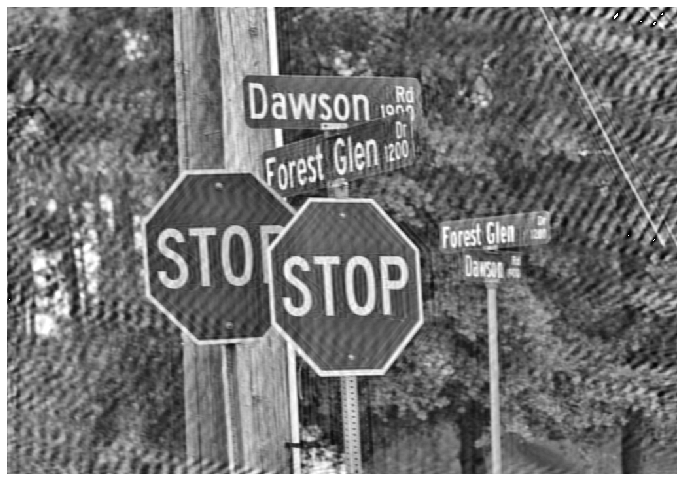

In [129]:
clahe = cv2.createCLAHE(clipLimit=1., tileGridSize=(15, 15))
img = clahe.apply(np.uint8(corrected_img*255.0))

img = img / 255.0

plot_image(img)

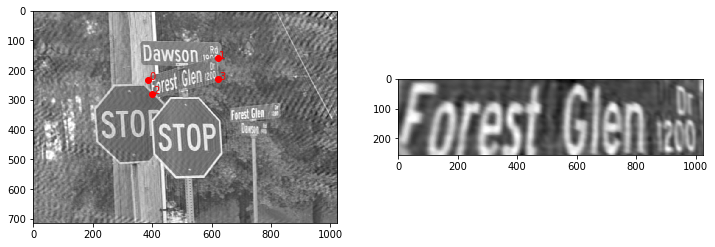

In [172]:
rows, cols = (256, 1024)

pts_original = np.float32([[386,232],[620,160],[400,280],[620,230]])
pts_corrigida = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1], [ cols - 1, rows - 1]])

M = cv2.getPerspectiveTransform(pts_original, pts_corrigida)

img_corrigida = cv2.warpPerspective(corrected_img, M, (cols, rows))

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(corrected_img, cmap='gray')
for k, p in enumerate(pts_original):
    plt.plot([p[0]], [p[1]], 'ro')
    plt.text(p[0] + 5, p[1], str(k), color='red')

plt.subplot(122)
plt.imshow(img_corrigida, cmap='gray')

plt.show()

## Tarefa

Escreva um programa que:

- Corrige o *motion blur*
    - Não é necessário neste projeto que o sistema escolha automaticamente os melhores parâmetros para o *deblurring*, determine-os manualmente.

- Melhora o contraste
    - Novamente, se precisar ajustar parâmetros manualmente, tudo bem. Escolha a técnica que quiser para melhoramento de contraste.
    
- Extrai a placa de rua com correção de perspectiva.
    - Os pontos dos cantos da placa não precisam ser determinados automaticamente, escolha manualmente os pontos. A outra parte da sua equipe está trabalhando no outro problema.
    

### Rubrica

- **I**: Entregou algo sem sentido ou muito incompleto (não atinge o nível *D*)

- **D**: Entregou o projeto quase completo, mas faltaram 2 itens dentre os descritos acima.

- **C**: Entregou o projeto quase completo, mas faltou 1 item dentre os descritos acima.

- **B**: Entregou o projeto completo.

- **A**: Entregou o projeto completo e testou alguma técnica mais avançada para resolver o problema do motion-blur. Ver o artigo "Restoration of Motion-Blurred Image Based on Border Deformation Detection: A Traffic Sign Restoration Model", em anexo no Blackboard.